# Income Estimation Analysis - ACS 2017 Census Data

## Project Overview
This project focuses on building a reproducible Python workflow to ingest, preprocess, and analyze ACS census tract data. The primary objective is to identify key drivers of household income and explore demographic and geographic trends through Exploratory Data Analysis (EDA).

### Key Objectives:
1. **Workflow Construction**: Standardized ingestion and missing-value handling.
2. **Data Cleaning**: Formatting features and managing data quality issues.
3. **Visual EDA**: Identifying trends, outliers, and drivers of income.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style and formatting
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:,.2f}'.format

## 1. Data Ingestion & Preprocessing

In this section, we load the dataset and perform initial cleaning to ensure data quality. This includes handling missing values and ensuring correct data types for numerical analysis.

In [2]:
def load_and_preprocess_data(filepath):
    filepath=r'/Users/sheetalsood/desktop/acs2017_census_tract_data.csv'
    df = pd.read_csv(filepath)
    
    # Initial shape
    print(f"Original dataset shape: {df.shape}")
    
    # Missing value handling: Income is our target
    # We drop rows where Income is missing as they cannot be used for estimation analysis
    df = df.dropna(subset=['Income'])
    
    # Fill other numerical missing values with median to handle data quality issues
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    
    print(f"Cleaned dataset shape: {df.shape}")
    return df

# Load data
df = load_and_preprocess_data('acs2017_census_tract_data.csv')
df.head()

Original dataset shape: (74001, 37)
Cleaned dataset shape: (72885, 37)


,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.40,86.30,5.20,0.00,...,0.50,0.00,2.10,24.50,881,74.20,21.20,4.50,0.00,4.60
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.10,41.60,54.50,0.00,...,0.00,0.50,0.00,22.20,852,75.90,15.00,9.00,0.00,3.40
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.00,61.40,26.50,0.60,...,1.00,0.80,1.50,23.10,1482,73.30,21.10,4.80,0.70,4.70
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.60,80.30,7.10,0.50,...,1.50,2.90,2.10,25.90,1849,75.80,19.70,4.50,0.00,6.10
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.90,77.50,16.40,0.00,...,0.80,0.30,0.70,21.00,4787,71.40,24.10,4.50,0.00,2.30


### Data Quality Check
Verifying if there are any remaining missing values after our imputation strategy.

In [3]:
print("Remaining missing values:")
print(df.isnull().sum().sum())

Remaining missing values:
0


## 2. Exploratory Data Analysis (EDA)

We analyze the distribution of `Income` and identify potential outliers across the dataset.

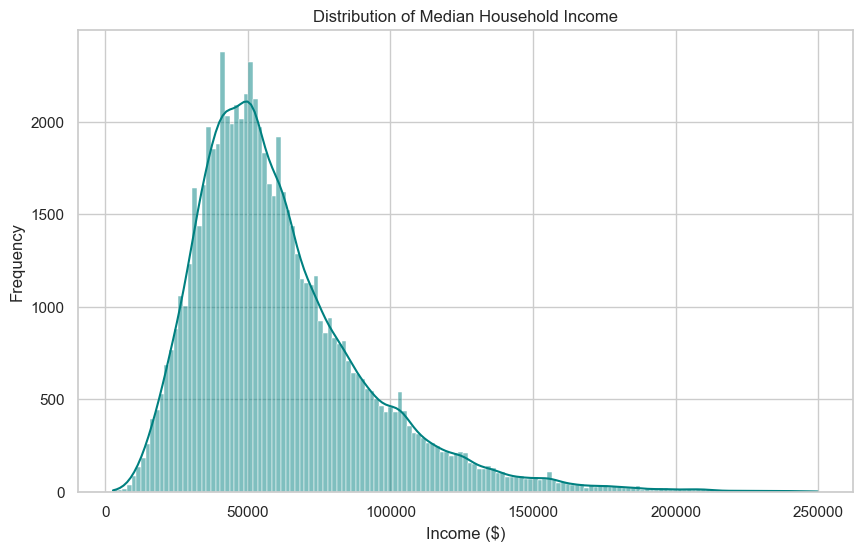

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], kde=True, color='teal')
plt.title('Distribution of Median Household Income')
plt.xlabel('Income ($)')
plt.ylabel('Frequency')
plt.show()

### Geographic Insights: Top 10 States by Median Tract Income
Identifying which states have the highest-income census tracts.

/var/folders/pc/k_s366t154549vflw72dgqd80000gn/T/ipykernel_23803/307007441.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_states, x='Income', y='State', palette='viridis', order=top_states)


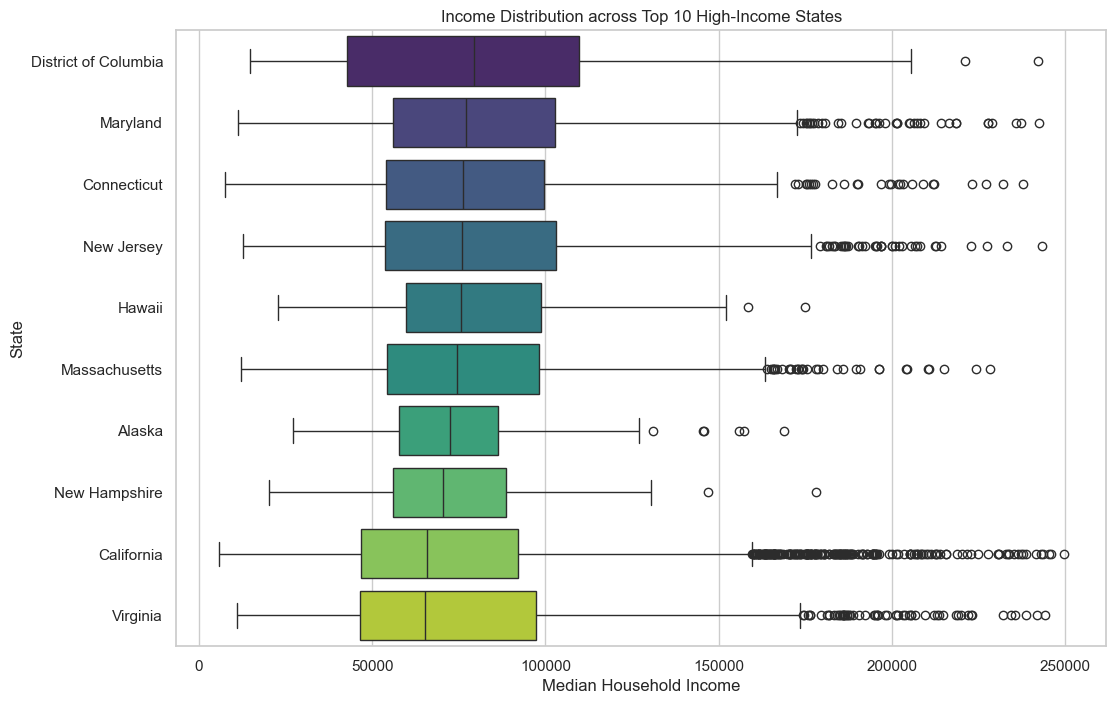

In [5]:
top_states = df.groupby('State')['Income'].median().sort_values(ascending=False).head(10).index
df_top_states = df[df['State'].isin(top_states)]

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_states, x='Income', y='State', palette='viridis', order=top_states)
plt.title('Income Distribution across Top 10 High-Income States')
plt.xlabel('Median Household Income')
plt.show()

## 3. Key Drivers of Income

Identifying correlations between demographic, occupational, and economic variables and the median income.

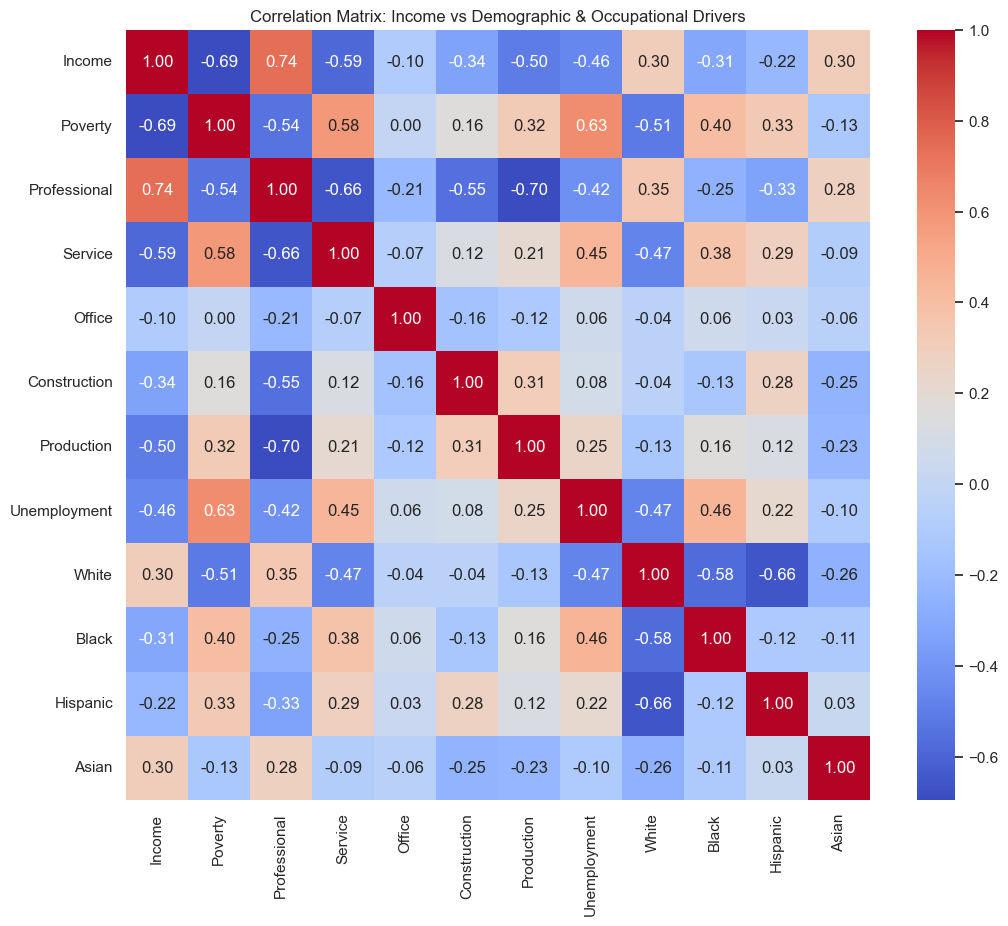

In [6]:
# Selecting relevant numerical features for correlation
cols_to_corr = ['Income', 'Poverty', 'Professional', 'Service', 'Office', 'Construction', 'Production', 'Unemployment', 'White', 'Black', 'Hispanic', 'Asian']
corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Income vs Demographic & Occupational Drivers')
plt.show()

### Visualizing Key Relationships
As seen in the heatmap, `Professional` employment and `Poverty` are the strongest predictors (drivers) of income.

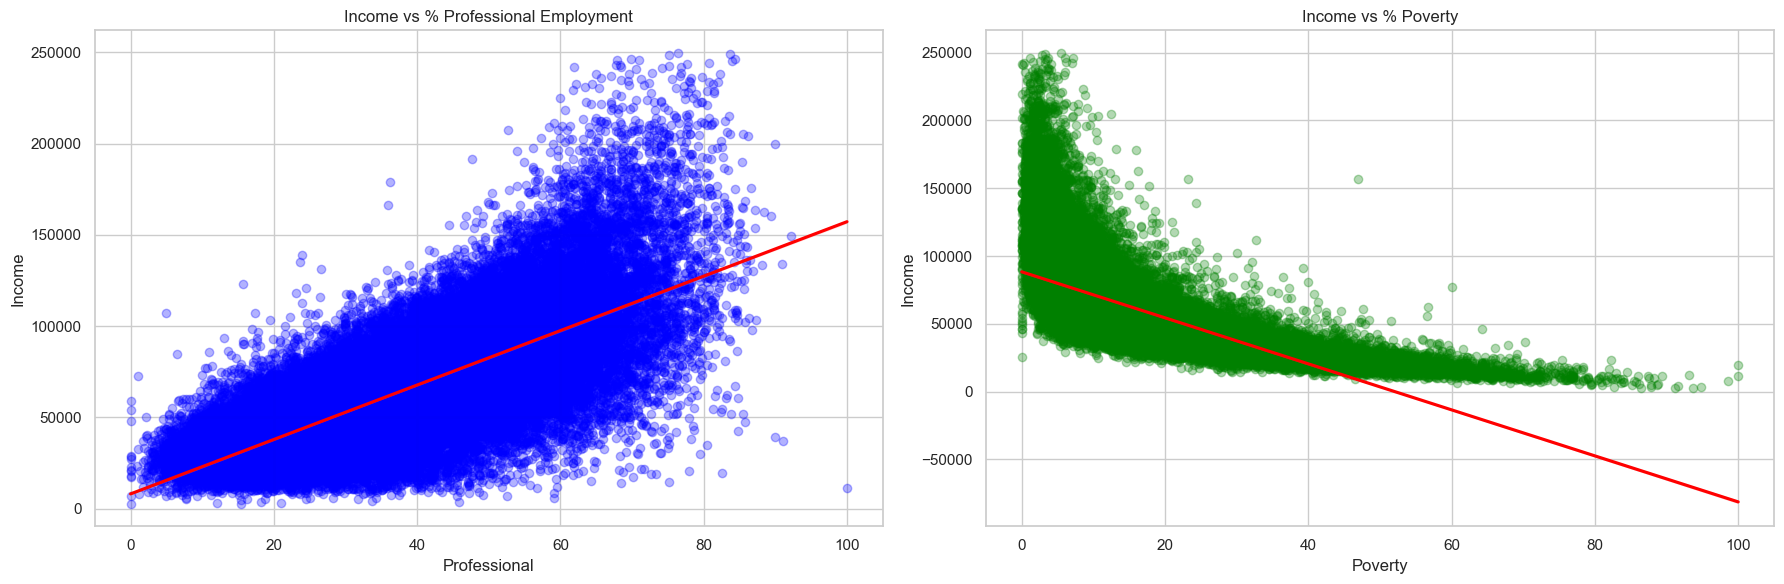

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Income vs Professional
sns.regplot(data=df, x='Professional', y='Income', ax=axes[0], scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red'})
axes[0].set_title('Income vs % Professional Employment')

# Income vs Poverty
sns.regplot(data=df, x='Poverty', y='Income', ax=axes[1], scatter_kws={'alpha':0.3, 'color':'green'}, line_kws={'color':'red'})
axes[1].set_title('Income vs % Poverty')

plt.tight_layout()
plt.show()

### Identifying Anomalies
Looking for 'high-income' outliers or tracts with mismatching economic indicators.

In [8]:
# Identifying tracts with very high income (> $200k)
high_income_tracts = df[df['Income'] >= 200000]
print(f"Number of census tracts with median income >= $200,000: {len(high_income_tracts)}")

# Visualizing outlier characteristics
# We exclude TractId as it is a unique identifier
summary_table = df.drop(columns=['TractId']).describe().T[['mean', '50%', 'max']]
summary_table

Number of census tracts with median income >= $200,000: 199


,mean,50%,max
TotalPop,"4,439.42","4,134.00","65,528.00"
Men,"2,182.32","2,022.00","32,266.00"
Women,"2,257.09","2,101.00","33,262.00"
Hispanic,17.26,7.40,100.00
White,61.37,70.50,100.00
Black,13.24,3.80,100.00
Native,0.73,0.00,99.40
Asian,4.76,1.50,91.40
Pacific,0.15,0.00,71.90
VotingAgeCitizen,"3,139.72","2,925.00","39,389.00"


## 5. Demographic Income Estimator

To make this analysis reproducible and actionable, we implement a simple function that estimates income trends for any specific demographic or occupational segment provided as input.

In [11]:
def analyze_demographic_impact(df, columns):
    """
    Analyzes how specific demographic or occupational columns relate to Income.
    Can accept a single column name or a list of columns to estimate combined impact.
    """
    if isinstance(columns, str):
        cols = [columns]
        display_name = columns
    else:
        cols = columns
        display_name = " + ".join(columns)
    
    valid_cols = [c for c in cols if c in df.columns]
    if not valid_cols:
        print(f"Error: None of the columns {cols} found in dataset.")
        return
    
    temp_col = 'Combined_Metric'
    df_temp = df.copy()
    df_temp[temp_col] = df_temp[valid_cols].sum(axis=1)
    
    # Statistical correlation
    correlation = df_temp[temp_col].corr(df_temp['Income'])
    
    # Segmenting 'High Concentration' areas (Top Quartile)
    threshold = df_temp[temp_col].quantile(0.75)
    high_concentration_df = df_temp[df_temp[temp_col] >= threshold]
    
    mean_inc = high_concentration_df['Income'].mean()
    med_inc = high_concentration_df['Income'].median()
    national_med = df_temp['Income'].median()
    
    # summary table data
    print(f"--- Impact Analysis for: {display_name} ---")
    print(f"Correlation with Income: {correlation:.2f}")
    print(f"Combined Concentration Threshold (75th percentile): {threshold:.2f}%")
    print(f"Estimated Mean Income (High Concentration areas): ${mean_inc:,.2f}")
    print(f"Estimated Median Income (High Concentration areas): ${med_inc:,.2f}")
    print(f"Comparison to National Median: {((med_inc/national_med - 1)*100):+.2f}%")
    
    # 4. Visualization of the trend
    plt.figure(figsize=(10, 5))
    sns.regplot(data=df_temp, x=temp_col, y='Income', 
                scatter_kws={'alpha':0.1, 'color':'gray'}, 
                line_kws={'color':'orange'})
    plt.title(f'Income Trend Analysis: {display_name}')
    plt.xlabel(f'Combined % of Population: {display_name}')
    plt.ylabel('Median Household Income')
    plt.show()

### Usage Example
You can input any column (e.g., 'Asian', 'Black', 'Professional', 'Transit') to see how it impacts income estimates.

--- Impact Analysis for: Professional ---
Correlation with Income: 0.74
Combined Concentration Threshold (75th percentile): 44.80%
Estimated Mean Income (High Concentration areas): $93,812.60
Estimated Median Income (High Concentration areas): $89,356.50
Comparison to National Median: +64.33%


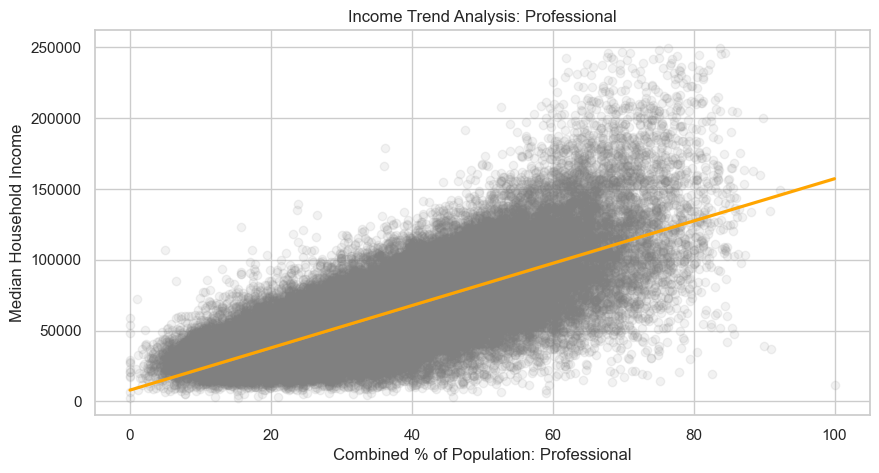

--- Impact Analysis for: White + Service ---
Correlation with Income: 0.17
Combined Concentration Threshold (75th percentile): 103.40%
Estimated Mean Income (High Concentration areas): $57,238.35
Estimated Median Income (High Concentration areas): $54,018.00
Comparison to National Median: -0.66%


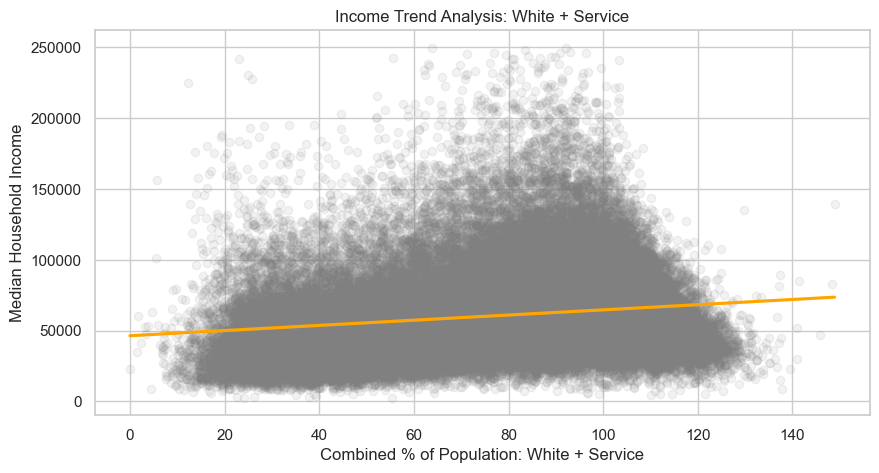

In [12]:
# Example 1: Single column analysis
analyze_demographic_impact(df, 'Professional')

# Example 2: Combined demographic impact (e.g., Service workers + Black population)
analyze_demographic_impact(df, ['White', 'Service'])

## 4. Summary & Findings

Based on the analysis, we have identified several key drivers and trends:
1. **Professional Work**: The strongest positive driver of tract income. Areas with higher concentrations of professional roles consistently show higher median incomes.
2. **Poverty & Unemployment**: These show the strongest negative correlations, as expected, but the analysis quantifies the impact across the nation.
3. **Geographic Variance**: Income is heavily skewed by geography, with the Northeast and Mid-Atlantic states showing significantly higher median tract incomes.
4. **Data Quality**: Handling missing values for Income was critical, as roughly 1.5% of the data lacked this key target variable.